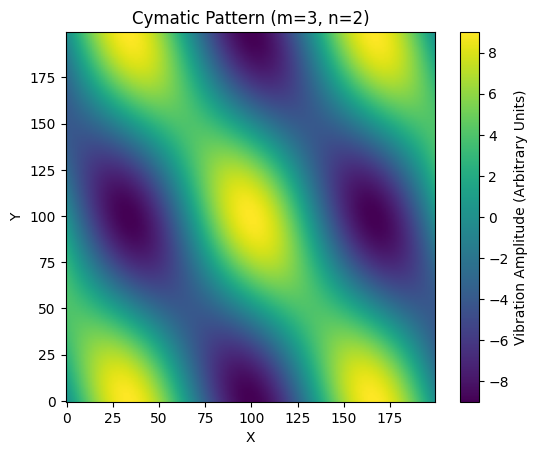

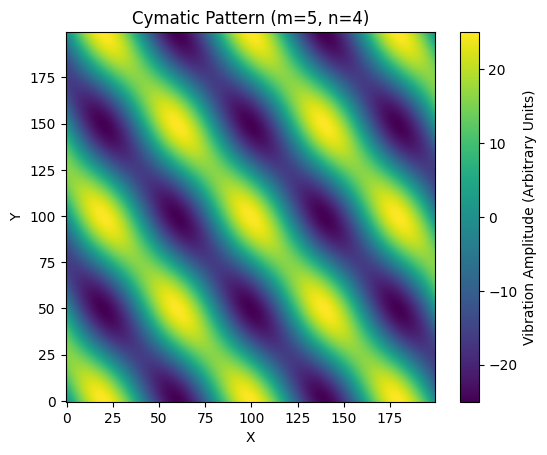

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def generate_chladni_pattern(m, n, size=200, frequency_factor=1.0):
    """
    Generates a Chladni-like pattern for a square plate.

    Args:
        m (int): Number of nodal lines in one direction.
        n (int): Number of nodal lines in the perpendicular direction.
        size (int): Size of the square plate (e.g., 200x200 pixels).
        frequency_factor (float): Adjusts the pattern's sensitivity to frequency.

    Returns:
        numpy.ndarray: A 2D array representing the pattern, where lower values
                       indicate nodal lines (where sand would gather).
    """
    x = np.linspace(0, np.pi, size)
    y = np.linspace(0, np.pi, size)
    X, Y = np.meshgrid(x, y)

    # Chladni patterns are often described by this formula, related to standing waves
    pattern = (m**2 * np.sin(m * X) * np.cos(n * Y) +
               n**2 * np.sin(n * Y) * np.cos(m * X))

    # You might want to apply a normalization or scaling factor here
    # to control the visual intensity of the patterns.
    # For a more "sand-like" effect, you might invert the values or threshold them.
    return pattern

def visualize_pattern(pattern, title="Cymatic Pattern"):
    """
    Visualizes the generated pattern.
    """
    plt.imshow(pattern, cmap='viridis', origin='lower')
    plt.colorbar(label='Vibration Amplitude (Arbitrary Units)')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

# Example usage:
# Adjust 'm' and 'n' to see different patterns. Higher numbers can simulate higher frequencies.
m_val = 3
n_val = 2
cymatic_pattern = generate_chladni_pattern(m_val, n_val)
visualize_pattern(cymatic_pattern, title=f"Cymatic Pattern (m={m_val}, n={n_val})")

m_val = 5
n_val = 4
cymatic_pattern_2 = generate_chladni_pattern(m_val, n_val)
visualize_pattern(cymatic_pattern_2, title=f"Cymatic Pattern (m={m_val}, n={n_val})")

In [4]:
! pip install PyAudio numpy pygame matplotlib scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 572.0 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 9.0 MB/s eta 0:00:0000:01:00:01

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [5]:
import numpy as np
import pygame
import pyaudio
import threading
import time
import math
from scipy.signal import find_peaks

# Audio configuration
CHUNK = 1024
FORMAT = pyaudio.paFloat32
CHANNELS = 1
RATE = 44100

# Pygame configuration
SCREEN_WIDTH = 800
SCREEN_HEIGHT = 800
NUM_PARTICLES = 1500
FPS = 60

class AudioProcessor:
    def __init__(self):
        self.p = pyaudio.PyAudio()
        self.stream = None
        self.dominant_frequency = 440.0
        self.running = False
        
    def start_stream(self):
        self.stream = self.p.open(
            format=FORMAT,
            channels=CHANNELS,
            rate=RATE,
            input=True,
            frames_per_buffer=CHUNK
        )
        self.running = True
        
    def get_dominant_frequency(self):
        if not self.stream:
            return self.dominant_frequency
            
        try:
            data = self.stream.read(CHUNK, exception_on_overflow=False)
            audio_data = np.frombuffer(data, dtype=np.float32)
            
            # Apply window function to reduce spectral leakage
            windowed = audio_data * np.hanning(len(audio_data))
            
            # Perform FFT
            fft = np.fft.rfft(windowed)
            magnitude = np.abs(fft)
            
            # Find frequency bins
            freqs = np.fft.rfftfreq(len(windowed), 1/RATE)
            
            # Find peaks in the spectrum
            peaks, _ = find_peaks(magnitude, height=np.max(magnitude) * 0.1)
            
            if len(peaks) > 0:
                # Get the frequency with the highest magnitude
                dominant_peak = peaks[np.argmax(magnitude[peaks])]
                self.dominant_frequency = freqs[dominant_peak]
                
                # Clamp frequency to reasonable range
                self.dominant_frequency = max(50, min(2000, self.dominant_frequency))
                
        except Exception as e:
            pass  # Keep previous frequency on error
            
        return self.dominant_frequency
    
    def stop_stream(self):
        self.running = False
        if self.stream:
            self.stream.stop_stream()
            self.stream.close()
        self.p.terminate()

class WaveSimulator:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.vibration_field = np.zeros((height, width))
        
    def calculate_vibration_field(self, frequency):
        # Map frequency to wave parameters
        # Higher frequencies create more complex patterns
        base_freq = frequency / 100.0
        m = max(1, int(base_freq * 0.5)) % 8 + 1
        n = max(1, int(base_freq * 0.3)) % 8 + 1
        
        # Create coordinate grids
        x = np.linspace(0, 2 * np.pi, self.width)
        y = np.linspace(0, 2 * np.pi, self.height)
        X, Y = np.meshgrid(x, y)
        
        # Generate standing wave pattern (Chladni-like)
        pattern1 = np.sin(m * X) * np.cos(n * Y)
        pattern2 = np.cos(m * X) * np.sin(n * Y)
        
        # Combine patterns for more complex interference
        self.vibration_field = (pattern1 + pattern2) * 0.5
        
        # Add some circular wave components for more organic patterns
        center_x, center_y = self.width // 2, self.height // 2
        radius = np.sqrt((X - np.pi)**2 + (Y - np.pi)**2)
        circular_wave = np.sin(frequency * 0.01 * radius) * 0.3
        
        self.vibration_field += circular_wave
        
        # Normalize the field
        self.vibration_field = np.tanh(self.vibration_field * 2)
        
        return self.vibration_field

class SandParticle:
    def __init__(self, x, y, screen_width, screen_height):
        self.x = x
        self.y = y
        self.vx = 0
        self.vy = 0
        self.screen_width = screen_width
        self.screen_height = screen_height
        self.size = np.random.uniform(1, 3)
        self.mass = self.size
        self.damping = 0.98
        self.color = (255, 180, 100)  # Sandy color
        
    def update(self, vibration_field):
        # Get grid coordinates
        grid_x = int(self.x * len(vibration_field[0]) / self.screen_width)
        grid_y = int(self.y * len(vibration_field) / self.screen_height)
        
        # Clamp to valid indices
        grid_x = max(0, min(len(vibration_field[0]) - 2, grid_x))
        grid_y = max(0, min(len(vibration_field) - 2, grid_y))
        
        # Calculate gradient (force direction)
        try:
            dx = vibration_field[grid_y, grid_x + 1] - vibration_field[grid_y, grid_x]
            dy = vibration_field[grid_y + 1, grid_x] - vibration_field[grid_y, grid_x]
        except IndexError:
            dx, dy = 0, 0
        
        # Force magnitude based on vibration intensity
        vibration_intensity = abs(vibration_field[grid_y, grid_x])
        force_multiplier = 50.0 * (1 + vibration_intensity)
        
        # Apply forces (particles move away from high vibration areas)
        self.vx -= dx * force_multiplier / self.mass
        self.vy -= dy * force_multiplier / self.mass
        
        # Add some random motion for realism
        self.vx += np.random.uniform(-0.5, 0.5)
        self.vy += np.random.uniform(-0.5, 0.5)
        
        # Apply damping
        self.vx *= self.damping
        self.vy *= self.damping
        
        # Update position
        self.x += self.vx
        self.y += self.vy
        
        # Boundary conditions - bounce off walls
        if self.x <= 0 or self.x >= self.screen_width:
            self.vx *= -0.5
            self.x = max(0, min(self.screen_width, self.x))
            
        if self.y <= 0 or self.y >= self.screen_height:
            self.vy *= -0.5
            self.y = max(0, min(self.screen_height, self.y))
    
    def draw(self, screen):
        # Color intensity based on speed
        speed = math.sqrt(self.vx**2 + self.vy**2)
        intensity = min(255, max(50, int(speed * 20 + 100)))
        color = (intensity, max(50, intensity - 50), 50)
        
        pygame.draw.circle(screen, color, (int(self.x), int(self.y)), int(self.size))

class CymaticsVisualizer:
    def __init__(self):
        pygame.init()
        self.screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
        pygame.display.set_caption("Cymatics Visualization - Real-time Sound Patterns")
        self.clock = pygame.time.Clock()
        
        # Initialize components
        self.audio_processor = AudioProcessor()
        self.wave_simulator = WaveSimulator(SCREEN_WIDTH // 4, SCREEN_HEIGHT // 4)
        
        # Create particles
        self.particles = []
        for _ in range(NUM_PARTICLES):
            x = np.random.uniform(50, SCREEN_WIDTH - 50)
            y = np.random.uniform(50, SCREEN_HEIGHT - 50)
            self.particles.append(SandParticle(x, y, SCREEN_WIDTH, SCREEN_HEIGHT))
        
        self.running = True
        self.show_field = False
        
    def draw_vibration_field(self, field):
        """Optional: Draw the vibration field as a background"""
        field_surface = pygame.Surface((SCREEN_WIDTH, SCREEN_HEIGHT))
        
        # Resize field to screen size
        resized_field = np.repeat(np.repeat(field, 4, axis=0), 4, axis=1)
        
        # Convert to color
        normalized = ((resized_field + 1) * 127.5).astype(np.uint8)
        
        for y in range(min(SCREEN_HEIGHT, resized_field.shape[0])):
            for x in range(min(SCREEN_WIDTH, resized_field.shape[1])):
                intensity = normalized[y, x]
                color = (0, 0, intensity)
                field_surface.set_at((x, y), color)
        
        field_surface.set_alpha(50)  # Make it semi-transparent
        self.screen.blit(field_surface, (0, 0))
    
    def draw_info(self, frequency):
        """Draw frequency and instructions"""
        font = pygame.font.Font(None, 36)
        
        # Frequency display
        freq_text = font.render(f"Frequency: {frequency:.1f} Hz", True, (255, 255, 255))
        self.screen.blit(freq_text, (10, 10))
        
        # Instructions
        info_font = pygame.font.Font(None, 24)
        instructions = [
            "Make sounds near your microphone to see patterns!",
            "Press SPACE to toggle vibration field view",
            "Press ESC to exit"
        ]
        
        for i, instruction in enumerate(instructions):
            text = info_font.render(instruction, True, (200, 200, 200))
            self.screen.blit(text, (10, SCREEN_HEIGHT - 80 + i * 25))
    
    def run(self):
        print("Starting cymatics visualization...")
        print("Make sounds near your microphone to see the patterns!")
        
        # Start audio processing
        self.audio_processor.start_stream()
        
        try:
            while self.running:
                # Handle events
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        self.running = False
                    elif event.type == pygame.KEYDOWN:
                        if event.key == pygame.K_ESCAPE:
                            self.running = False
                        elif event.key == pygame.K_SPACE:
                            self.show_field = not self.show_field
                
                # Get current frequency
                frequency = self.audio_processor.get_dominant_frequency()
                
                # Update wave simulation
                vibration_field = self.wave_simulator.calculate_vibration_field(frequency)
                
                # Clear screen
                self.screen.fill((20, 20, 40))  # Dark blue background
                
                # Optionally draw vibration field
                if self.show_field:
                    self.draw_vibration_field(vibration_field)
                
                # Update and draw particles
                for particle in self.particles:
                    particle.update(vibration_field)
                    particle.draw(self.screen)
                
                # Draw info
                self.draw_info(frequency)
                
                # Update display
                pygame.display.flip()
                self.clock.tick(FPS)
                
        except KeyboardInterrupt:
            print("\nShutting down...")
        finally:
            self.cleanup()
    
    def cleanup(self):
        self.audio_processor.stop_stream()
        pygame.quit()

def main():
    print("Cymatics Visualizer")
    print("===================")
    print("This program creates real-time visual patterns based on sound input.")
    print("Make sure your microphone is working and try:")
    print("- Singing or humming different notes")
    print("- Playing music")
    print("- Making various sounds")
    print("\nStarting in 3 seconds...")
    
    time.sleep(3)
    
    visualizer = CymaticsVisualizer()
    visualizer.run()

if __name__ == "__main__":
    main()

Cymatics Visualizer
This program creates real-time visual patterns based on sound input.
Make sure your microphone is working and try:
- Singing or humming different notes
- Playing music
- Making various sounds

Starting in 3 seconds...
Starting cymatics visualization...
Make sounds near your microphone to see the patterns!


In [6]:
import numpy as np
import pygame
import pyaudio
import threading
import time
import math
from scipy.signal import find_peaks

# Audio configuration
CHUNK = 1024
FORMAT = pyaudio.paFloat32
CHANNELS = 1
RATE = 44100

# Pygame configuration
SCREEN_WIDTH = 800
SCREEN_HEIGHT = 800
NUM_PARTICLES = 1500
FPS = 60

class AudioProcessor:
    def __init__(self):
        self.p = pyaudio.PyAudio()
        self.stream = None
        self.dominant_frequency = 440.0
        self.running = False
        
    def start_stream(self):
        self.stream = self.p.open(
            format=FORMAT,
            channels=CHANNELS,
            rate=RATE,
            input=True,
            frames_per_buffer=CHUNK
        )
        self.running = True
        
    def get_dominant_frequency(self):
        if not self.stream:
            return self.dominant_frequency
            
        try:
            data = self.stream.read(CHUNK, exception_on_overflow=False)
            audio_data = np.frombuffer(data, dtype=np.float32)
            
            # Apply window function to reduce spectral leakage
            windowed = audio_data * np.hanning(len(audio_data))
            
            # Perform FFT
            fft = np.fft.rfft(windowed)
            magnitude = np.abs(fft)
            
            # Find frequency bins
            freqs = np.fft.rfftfreq(len(windowed), 1/RATE)
            
            # Find peaks in the spectrum
            peaks, _ = find_peaks(magnitude, height=np.max(magnitude) * 0.1)
            
            if len(peaks) > 0:
                # Get the frequency with the highest magnitude
                dominant_peak = peaks[np.argmax(magnitude[peaks])]
                self.dominant_frequency = freqs[dominant_peak]
                
                # Clamp frequency to reasonable range
                self.dominant_frequency = max(50, min(2000, self.dominant_frequency))
                
        except Exception as e:
            pass  # Keep previous frequency on error
            
        return self.dominant_frequency
    
    def stop_stream(self):
        self.running = False
        if self.stream:
            self.stream.stop_stream()
            self.stream.close()
        self.p.terminate()

class WaveSimulator:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.vibration_field = np.zeros((height, width))
        
    def calculate_vibration_field(self, frequency):
        # Create coordinate grids centered at the middle
        x = np.linspace(-1, 1, self.width)
        y = np.linspace(-1, 1, self.height)
        X, Y = np.meshgrid(x, y)
        
        # Calculate radial distance from center
        R = np.sqrt(X**2 + Y**2)
        
        # Calculate angle for angular patterns
        THETA = np.arctan2(Y, X)
        
        # Map frequency to pattern parameters
        # Higher frequencies create more complex radial and angular patterns
        freq_factor = frequency / 50.0  # Scale frequency
        
        # Number of radial rings (increases with frequency)
        radial_freq = max(1, freq_factor * 0.8)
        
        # Number of angular segments (increases with frequency)
        angular_freq = max(1, int(freq_factor * 0.3)) % 12 + 1
        
        # Create radial wave pattern (concentric circles)
        radial_pattern = np.sin(radial_freq * R * 2 * np.pi)
        
        # Create angular wave pattern (petals/segments)
        angular_pattern = np.cos(angular_freq * THETA)
        
        # Combine radial and angular patterns
        self.vibration_field = radial_pattern * angular_pattern
        
        # Add some complexity with higher harmonics
        if frequency > 100:
            harmonic_radial = np.sin(radial_freq * 1.5 * R * 2 * np.pi) * 0.3
            harmonic_angular = np.cos((angular_freq * 1.5) * THETA) * 0.3
            self.vibration_field += harmonic_radial * harmonic_angular
        
        # Apply a circular boundary to simulate a circular plate
        # Fade out vibrations near the edges
        edge_factor = np.exp(-3 * (R - 0.8)**2 * (R > 0.8))
        self.vibration_field *= edge_factor
        
        # Add some radial decay for more realistic patterns
        radial_decay = np.exp(-0.5 * R)
        self.vibration_field *= radial_decay
        
        # Normalize and enhance contrast
        self.vibration_field = np.tanh(self.vibration_field * 3)
        
        return self.vibration_field

class SandParticle:
    def __init__(self, x, y, screen_width, screen_height):
        self.x = x
        self.y = y
        self.vx = 0
        self.vy = 0
        self.screen_width = screen_width
        self.screen_height = screen_height
        self.size = np.random.uniform(1, 2.5)
        self.mass = self.size
        self.damping = 0.95
        self.color = (255, 220, 120)  # Sandy golden color
        
        # Add settling behavior
        self.settled = False
        self.settle_threshold = 0.1
        
    def update(self, vibration_field):
        # Get grid coordinates
        grid_x = int(self.x * len(vibration_field[0]) / self.screen_width)
        grid_y = int(self.y * len(vibration_field) / self.screen_height)
        
        # Clamp to valid indices
        grid_x = max(0, min(len(vibration_field[0]) - 2, grid_x))
        grid_y = max(0, min(len(vibration_field) - 2, grid_y))
        
        # Get current vibration intensity
        current_vibration = abs(vibration_field[grid_y, grid_x])
        
        # Calculate gradient (force direction) using neighboring points
        try:
            dx = vibration_field[grid_y, min(grid_x + 1, len(vibration_field[0]) - 1)] - vibration_field[grid_y, max(grid_x - 1, 0)]
            dy = vibration_field[min(grid_y + 1, len(vibration_field) - 1), grid_x] - vibration_field[max(grid_y - 1, 0), grid_x]
        except IndexError:
            dx, dy = 0, 0
        
        # Stronger force away from high vibration areas (antinodes)
        # Particles settle in low vibration areas (nodes)
        if current_vibration > 0.3:  # High vibration area
            force_multiplier = 80.0 * current_vibration
            self.vx -= dx * force_multiplier / self.mass
            self.vy -= dy * force_multiplier / self.mass
            self.settled = False
        else:  # Low vibration area - allow settling
            force_multiplier = 10.0
            self.vx -= dx * force_multiplier / self.mass
            self.vy -= dy * force_multiplier / self.mass
            
            # Check if particle should settle
            speed = math.sqrt(self.vx**2 + self.vy**2)
            if speed < self.settle_threshold and current_vibration < 0.2:
                self.settled = True
                self.vx *= 0.8  # Heavy damping when settled
                self.vy *= 0.8
        
        # Add minimal random motion only if not settled
        if not self.settled:
            self.vx += np.random.uniform(-0.2, 0.2)
            self.vy += np.random.uniform(-0.2, 0.2)
        
        # Apply damping
        self.vx *= self.damping
        self.vy *= self.damping
        
        # Update position
        self.x += self.vx
        self.y += self.vy
        
        # Boundary conditions - particles stay within circular boundary
        center_x, center_y = self.screen_width // 2, self.screen_height // 2
        max_radius = min(self.screen_width, self.screen_height) * 0.45
        
        dx_center = self.x - center_x
        dy_center = self.y - center_y
        distance_from_center = math.sqrt(dx_center**2 + dy_center**2)
        
        if distance_from_center > max_radius:
            # Push particle back toward center
            angle = math.atan2(dy_center, dx_center)
            self.x = center_x + math.cos(angle) * max_radius
            self.y = center_y + math.sin(angle) * max_radius
            
            # Reverse velocity component pointing outward
            self.vx = -self.vx * 0.3
            self.vy = -self.vy * 0.3
    
    def draw(self, screen):
        # Color based on settled state and vibration
        if self.settled:
            # Brighter color for settled particles (forming the pattern)
            color = (255, 235, 150)
            size = self.size * 1.2
        else:
            # Dimmer color for moving particles
            speed = math.sqrt(self.vx**2 + self.vy**2)
            intensity = min(255, max(100, int(speed * 30 + 150)))
            color = (intensity, intensity - 30, 80)
            size = self.size
        
        pygame.draw.circle(screen, color, (int(self.x), int(self.y)), int(size))

class CymaticsVisualizer:
    def __init__(self):
        pygame.init()
        self.screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
        pygame.display.set_caption("Cymatics Visualization - Real-time Sound Patterns")
        self.clock = pygame.time.Clock()
        
        # Initialize components
        self.audio_processor = AudioProcessor()
        self.wave_simulator = WaveSimulator(SCREEN_WIDTH // 4, SCREEN_HEIGHT // 4)
        
        # Create particles in a circular distribution around the center
        self.particles = []
        center_x, center_y = SCREEN_WIDTH // 2, SCREEN_HEIGHT // 2
        max_radius = min(SCREEN_WIDTH, SCREEN_HEIGHT) * 0.4
        
        for _ in range(NUM_PARTICLES):
            # Distribute particles in a circle
            angle = np.random.uniform(0, 2 * np.pi)
            radius = np.random.uniform(0, max_radius)
            x = center_x + radius * np.cos(angle)
            y = center_y + radius * np.sin(angle)
            self.particles.append(SandParticle(x, y, SCREEN_WIDTH, SCREEN_HEIGHT))
        
        self.running = True
        self.show_field = False
        
    def draw_vibration_field(self, field):
        """Optional: Draw the vibration field as a background"""
        field_surface = pygame.Surface((SCREEN_WIDTH, SCREEN_HEIGHT))
        
        # Resize field to screen size
        resized_field = np.repeat(np.repeat(field, 4, axis=0), 4, axis=1)
        
        # Convert to color with better contrast
        normalized = ((resized_field + 1) * 127.5).astype(np.uint8)
        
        for y in range(min(SCREEN_HEIGHT, resized_field.shape[0])):
            for x in range(min(SCREEN_WIDTH, resized_field.shape[1])):
                intensity = normalized[y, x]
                # Use blue-white color scheme for better visibility
                color = (intensity // 4, intensity // 2, intensity)
                field_surface.set_at((x, y), color)
        
        field_surface.set_alpha(80)  # Make it more visible
        self.screen.blit(field_surface, (0, 0))
    
    def draw_info(self, frequency):
        """Draw frequency and instructions"""
        font = pygame.font.Font(None, 36)
        
        # Frequency display
        freq_text = font.render(f"Frequency: {frequency:.1f} Hz", True, (255, 255, 255))
        self.screen.blit(freq_text, (10, 10))
        
        # Instructions
        info_font = pygame.font.Font(None, 24)
        instructions = [
            "Make sounds near your microphone to see patterns!",
            "Press SPACE to toggle vibration field view",
            "Press ESC to exit"
        ]
        
        for i, instruction in enumerate(instructions):
            text = info_font.render(instruction, True, (200, 200, 200))
            self.screen.blit(text, (10, SCREEN_HEIGHT - 80 + i * 25))
    
    def run(self):
        print("Starting cymatics visualization...")
        print("Make sounds near your microphone to see the patterns!")
        
        # Start audio processing
        self.audio_processor.start_stream()
        
        try:
            while self.running:
                # Handle events
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        self.running = False
                    elif event.type == pygame.KEYDOWN:
                        if event.key == pygame.K_ESCAPE:
                            self.running = False
                        elif event.key == pygame.K_SPACE:
                            self.show_field = not self.show_field
                
                # Get current frequency
                frequency = self.audio_processor.get_dominant_frequency()
                
                # Update wave simulation
                vibration_field = self.wave_simulator.calculate_vibration_field(frequency)
                
                # Clear screen with dark background
                self.screen.fill((10, 15, 25))  # Very dark blue background
                
                # Draw a subtle circular boundary
                center = (SCREEN_WIDTH // 2, SCREEN_HEIGHT // 2)
                radius = min(SCREEN_WIDTH, SCREEN_HEIGHT) // 2 - 50
                pygame.draw.circle(self.screen, (30, 40, 60), center, radius, 2)
                
                # Optionally draw vibration field
                if self.show_field:
                    self.draw_vibration_field(vibration_field)
                
                # Update and draw particles
                for particle in self.particles:
                    particle.update(vibration_field)
                    particle.draw(self.screen)
                
                # Draw info
                self.draw_info(frequency)
                
                # Update display
                pygame.display.flip()
                self.clock.tick(FPS)
                
        except KeyboardInterrupt:
            print("\nShutting down...")
        finally:
            self.cleanup()
    
    def cleanup(self):
        self.audio_processor.stop_stream()
        pygame.quit()

def main():
    print("Cymatics Visualizer")
    print("===================")
    print("This program creates real-time visual patterns based on sound input.")
    print("Make sure your microphone is working and try:")
    print("- Singing or humming different notes")
    print("- Playing music")
    print("- Making various sounds")
    print("\nStarting in 3 seconds...")
    
    time.sleep(3)
    
    visualizer = CymaticsVisualizer()
    visualizer.run()

if __name__ == "__main__":
    main()

Cymatics Visualizer
This program creates real-time visual patterns based on sound input.
Make sure your microphone is working and try:
- Singing or humming different notes
- Playing music
- Making various sounds

Starting in 3 seconds...
Starting cymatics visualization...
Make sounds near your microphone to see the patterns!

Shutting down...


In [1]:
import numpy as np
import pygame
import pyaudio
import threading
import time
import math
from scipy.signal import find_peaks
from scipy.special import jv, jn_zeros
import colorsys

# Audio configuration
CHUNK = 1024
FORMAT = pyaudio.paFloat32
CHANNELS = 1
RATE = 44100

# Pygame configuration
SCREEN_WIDTH = 800
SCREEN_HEIGHT = 800
NUM_PARTICLES = 2000
FPS = 60

class AudioProcessor:
    def __init__(self):
        self.p = pyaudio.PyAudio()
        self.stream = None
        self.frequencies = []  # Multiple frequencies
        self.amplitudes = []   # Corresponding amplitudes
        self.running = False
        
    def start_stream(self):
        self.stream = self.p.open(
            format=FORMAT,
            channels=CHANNELS,
            rate=RATE,
            input=True,
            frames_per_buffer=CHUNK
        )
        self.running = True
        
    def analyze_frequencies(self):
        if not self.stream:
            return self.frequencies, self.amplitudes
            
        try:
            data = self.stream.read(CHUNK, exception_on_overflow=False)
            audio_data = np.frombuffer(data, dtype=np.float32)
            
            # Apply window function
            windowed = audio_data * np.hanning(len(audio_data))
            
            # Perform FFT
            fft = np.fft.rfft(windowed)
            magnitude = np.abs(fft)
            
            # Get frequency bins
            freqs = np.fft.rfftfreq(len(windowed), 1/RATE)
            
            # Find prominent peaks (multiple frequencies)
            peaks, properties = find_peaks(magnitude, 
                                         height=np.max(magnitude) * 0.1,
                                         distance=10)
            
            if len(peaks) > 0:
                # Get top 5 frequencies and their amplitudes
                peak_indices = peaks[np.argsort(magnitude[peaks])[-5:]][::-1]
                
                self.frequencies = []
                self.amplitudes = []
                
                for peak_idx in peak_indices:
                    freq = freqs[peak_idx]
                    amp = magnitude[peak_idx]
                    
                    if 50 <= freq <= 2000:  # Valid frequency range
                        self.frequencies.append(freq)
                        self.amplitudes.append(amp)
                
                # Normalize amplitudes
                if self.amplitudes:
                    max_amp = max(self.amplitudes)
                    self.amplitudes = [amp / max_amp for amp in self.amplitudes]
                    
        except Exception as e:
            pass
            
        return self.frequencies, self.amplitudes
    
    def stop_stream(self):
        self.running = False
        if self.stream:
            self.stream.stop_stream()
            self.stream.close()
        self.p.terminate()

class WaveSimulator:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.vibration_field = np.zeros((height, width))
        self.frequency_fields = []  # Store separate fields for each frequency
        
    def bessel_pattern(self, frequency, amplitude, x_grid, y_grid, R):
        """Generate Bessel function-based patterns for circular membranes"""
        # Map frequency to Bessel function parameters
        freq_factor = frequency / 100.0
        m = int(freq_factor * 0.2) % 6  # Angular mode (0-5)
        n = max(1, int(freq_factor * 0.1)) % 4 + 1  # Radial mode (1-4)
        
        # Get Bessel function zeros for proper scaling
        try:
            zeros = jn_zeros(m, n)
            if len(zeros) >= n:
                alpha = zeros[n-1]
            else:
                alpha = 3.83 * n  # Approximation if zeros not available
        except:
            alpha = 3.83 * n
        
        # Scale radial coordinate
        scaled_r = alpha * R / np.max(R)
        
        # Calculate Bessel function pattern
        bessel_radial = jv(m, scaled_r)
        
        # Add angular component for asymmetric modes
        if m > 0:
            theta = np.arctan2(y_grid, x_grid)
            angular_component = np.cos(m * theta)
            pattern = bessel_radial * angular_component
        else:
            pattern = bessel_radial
        
        # Apply amplitude and boundary conditions
        boundary_factor = np.exp(-2 * (R - 0.8)**2 * (R > 0.8))
        pattern *= amplitude * boundary_factor
        
        return pattern
    
    def calculate_multi_frequency_field(self, frequencies, amplitudes):
        """Calculate interference patterns from multiple frequencies"""
        # Create coordinate grids
        x = np.linspace(-1, 1, self.width)
        y = np.linspace(-1, 1, self.height)
        X, Y = np.meshgrid(x, y)
        
        # Calculate radial distance from center
        R = np.sqrt(X**2 + Y**2)
        
        # Reset fields
        self.vibration_field = np.zeros((self.height, self.width))
        self.frequency_fields = []
        
        # Process each frequency separately
        for i, (freq, amp) in enumerate(zip(frequencies, amplitudes)):
            if amp > 0.1:  # Only process significant amplitudes
                # Generate Bessel pattern for this frequency
                pattern = self.bessel_pattern(freq, amp, X, Y, R)
                
                # Add concentric wave components
                radial_freq = freq / 50.0
                concentric_waves = np.sin(radial_freq * R * 2 * np.pi) * amp * 0.3
                pattern += concentric_waves
                
                # Store individual frequency field for color coding
                self.frequency_fields.append({
                    'pattern': pattern,
                    'frequency': freq,
                    'amplitude': amp,
                    'color_hue': (freq % 360) / 360.0  # Color based on frequency
                })
                
                # Add to combined field
                self.vibration_field += pattern
        
        # Add interference effects between frequencies
        if len(frequencies) > 1:
            for i in range(len(frequencies)):
                for j in range(i+1, len(frequencies)):
                    freq1, freq2 = frequencies[i], frequencies[j]
                    amp1, amp2 = amplitudes[i], amplitudes[j]
                    
                    # Beat frequency interference
                    beat_freq = abs(freq1 - freq2)
                    if beat_freq > 0:
                        beat_pattern = np.sin(beat_freq * time.time() * 0.1) * 0.2
                        beat_spatial = np.sin((freq1 + freq2) / 100.0 * R * 2 * np.pi)
                        interference = beat_pattern * beat_spatial * amp1 * amp2 * 0.5
                        self.vibration_field += interference
        
        # Normalize and enhance contrast
        if np.max(np.abs(self.vibration_field)) > 0:
            self.vibration_field = np.tanh(self.vibration_field * 2)
        
        return self.vibration_field

class SandParticle:
    def __init__(self, x, y, screen_width, screen_height):
        self.x = x
        self.y = y
        self.vx = 0
        self.vy = 0
        self.screen_width = screen_width
        self.screen_height = screen_height
        self.size = np.random.uniform(0.8, 2.0)
        self.mass = self.size
        self.damping = 0.92
        
        # Enhanced color properties
        self.base_color = (255, 220, 100)
        self.frequency_influence = 0.0
        self.dominant_frequency = 440.0
        
        # Settling behavior
        self.settled = False
        self.settle_threshold = 0.05
        self.settle_time = 0
        
    def update(self, vibration_field, frequency_fields):
        # Get grid coordinates
        grid_x = int(self.x * len(vibration_field[0]) / self.screen_width)
        grid_y = int(self.y * len(vibration_field) / self.screen_height)
        
        # Clamp to valid indices
        grid_x = max(1, min(len(vibration_field[0]) - 2, grid_x))
        grid_y = max(1, min(len(vibration_field) - 2, grid_y))
        
        # Get current vibration intensity
        current_vibration = abs(vibration_field[grid_y, grid_x])
        
        # Calculate gradient (force direction)
        dx = vibration_field[grid_y, min(grid_x + 1, len(vibration_field[0]) - 1)] - \
             vibration_field[grid_y, max(grid_x - 1, 0)]
        dy = vibration_field[min(grid_y + 1, len(vibration_field) - 1), grid_x] - \
             vibration_field[max(grid_y - 1, 0), grid_x]
        
        # Enhanced force calculation
        if current_vibration > 0.2:  # High vibration area
            force_multiplier = 120.0 * current_vibration
            self.vx -= dx * force_multiplier / self.mass
            self.vy -= dy * force_multiplier / self.mass
            self.settled = False
            self.settle_time = 0
        else:  # Low vibration area - nodal regions
            force_multiplier = 15.0
            self.vx -= dx * force_multiplier / self.mass
            self.vy -= dy * force_multiplier / self.mass
            
            # Enhanced settling in nodal lines
            speed = math.sqrt(self.vx**2 + self.vy**2)
            if speed < self.settle_threshold and current_vibration < 0.15:
                self.settle_time += 1
                if self.settle_time > 10:  # Require sustained low motion
                    self.settled = True
                    self.vx *= 0.7
                    self.vy *= 0.7
        
        # Determine dominant frequency influence for color
        max_influence = 0
        for field_data in frequency_fields:
            try:
                field_value = abs(field_data['pattern'][grid_y, grid_x])
                if field_value > max_influence:
                    max_influence = field_value
                    self.dominant_frequency = field_data['frequency']
                    self.frequency_influence = field_data['amplitude']
            except:
                pass
        
        # Minimal random motion only if not settled
        if not self.settled:
            self.vx += np.random.uniform(-0.1, 0.1)
            self.vy += np.random.uniform(-0.1, 0.1)
        
        # Apply damping
        self.vx *= self.damping
        self.vy *= self.damping
        
        # Update position
        self.x += self.vx
        self.y += self.vy
        
        # Circular boundary conditions
        center_x, center_y = self.screen_width // 2, self.screen_height // 2
        max_radius = min(self.screen_width, self.screen_height) * 0.45
        
        dx_center = self.x - center_x
        dy_center = self.y - center_y
        distance_from_center = math.sqrt(dx_center**2 + dy_center**2)
        
        if distance_from_center > max_radius:
            angle = math.atan2(dy_center, dx_center)
            self.x = center_x + math.cos(angle) * max_radius * 0.95
            self.y = center_y + math.sin(angle) * max_radius * 0.95
            self.vx *= -0.3
            self.vy *= -0.3
    
    def get_color(self):
        """Calculate particle color based on frequency influence"""
        if self.settled:
            # Color based on dominant frequency for settled particles
            hue = (self.dominant_frequency % 360) / 360.0
            saturation = min(1.0, self.frequency_influence * 2)
            value = 0.9  # Bright for settled particles
            
            rgb = colorsys.hsv_to_rgb(hue, saturation, value)
            return tuple(int(c * 255) for c in rgb)
        else:
            # Dimmer, more neutral color for moving particles
            speed = math.sqrt(self.vx**2 + self.vy**2)
            intensity = min(255, max(80, int(speed * 40 + 120)))
            return (intensity, intensity - 20, 60)
    
    def draw(self, screen):
        color = self.get_color()
        size = self.size * (1.3 if self.settled else 1.0)
        pygame.draw.circle(screen, color, (int(self.x), int(self.y)), int(size))

class CymaticsVisualizer:
    def __init__(self):
        pygame.init()
        self.screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
        pygame.display.set_caption("Advanced Cymatics - Multi-Frequency Wave Interference")
        self.clock = pygame.time.Clock()
        
        # Initialize components
        self.audio_processor = AudioProcessor()
        self.wave_simulator = WaveSimulator(SCREEN_WIDTH // 3, SCREEN_HEIGHT // 3)
        
        # Create particles in circular distribution
        self.particles = []
        center_x, center_y = SCREEN_WIDTH // 2, SCREEN_HEIGHT // 2
        max_radius = min(SCREEN_WIDTH, SCREEN_HEIGHT) * 0.4
        
        for _ in range(NUM_PARTICLES):
            # More concentrated distribution near center
            angle = np.random.uniform(0, 2 * np.pi)
            radius = np.random.beta(2, 5) * max_radius  # Beta distribution for center concentration
            x = center_x + radius * np.cos(angle)
            y = center_y + radius * np.sin(angle)
            self.particles.append(SandParticle(x, y, SCREEN_WIDTH, SCREEN_HEIGHT))
        
        self.running = True
        self.show_field = False
        self.show_frequency_info = True
        
    def draw_vibration_field(self, field, frequency_fields):
        """Draw multi-frequency field with color coding"""
        field_surface = pygame.Surface((SCREEN_WIDTH, SCREEN_HEIGHT))
        field_surface.set_alpha(60)
        
        # Resize field to screen size
        scale_x = SCREEN_WIDTH // field.shape[1]
        scale_y = SCREEN_HEIGHT // field.shape[0]
        
        for y in range(field.shape[0]):
            for x in range(field.shape[1]):
                intensity = abs(field[y, x])
                
                # Determine dominant frequency at this point
                max_influence = 0
                dominant_hue = 0
                for field_data in frequency_fields:
                    try:
                        field_value = abs(field_data['pattern'][y, x])
                        if field_value > max_influence:
                            max_influence = field_value
                            dominant_hue = field_data['color_hue']
                    except:
                        pass
                
                if intensity > 0.1:
                    # Convert HSV to RGB for frequency-based coloring
                    rgb = colorsys.hsv_to_rgb(dominant_hue, 0.8, intensity)
                    color = tuple(int(c * 255) for c in rgb)
                    
                    # Draw scaled pixel
                    rect = pygame.Rect(x * scale_x, y * scale_y, scale_x, scale_y)
                    pygame.draw.rect(field_surface, color, rect)
        
        self.screen.blit(field_surface, (0, 0))
    
    def draw_frequency_info(self, frequencies, amplitudes):
        """Draw frequency analysis information"""
        font_large = pygame.font.Font(None, 32)
        font_small = pygame.font.Font(None, 24)
        
        y_offset = 10
        
        # Title
        title_text = font_large.render("Multi-Frequency Analysis", True, (255, 255, 255))
        self.screen.blit(title_text, (10, y_offset))
        y_offset += 40
        
        # Frequency list
        for i, (freq, amp) in enumerate(zip(frequencies, amplitudes)):
            if i >= 5:  # Limit display to top 5
                break
                
            # Color based on frequency
            hue = (freq % 360) / 360.0
            rgb = colorsys.hsv_to_rgb(hue, 0.8, 1.0)
            color = tuple(int(c * 255) for c in rgb)
            
            # Frequency text
            freq_text = font_small.render(f"{freq:.1f}Hz", True, color)
            self.screen.blit(freq_text, (10, y_offset))
            
            # Amplitude bar
            bar_width = int(amp * 100)
            if bar_width > 0:
                pygame.draw.rect(self.screen, color, 
                               (100, y_offset + 5, bar_width, 15))
            
            y_offset += 25
        
        # Instructions
        instructions = [
            "Multi-frequency cymatics simulation",
            "SPACE: Toggle field visualization",
            "F: Toggle frequency display",
            "ESC: Exit"
        ]
        
        info_font = pygame.font.Font(None, 20)
        for i, instruction in enumerate(instructions):
            text = info_font.render(instruction, True, (180, 180, 180))
            self.screen.blit(text, (10, SCREEN_HEIGHT - 100 + i * 22))
    
    def draw_circular_boundary(self):
        """Draw the circular plate boundary with resonance indicators"""
        center = (SCREEN_WIDTH // 2, SCREEN_HEIGHT // 2)
        radius = min(SCREEN_WIDTH, SCREEN_HEIGHT) // 2 - 50
        
        # Main boundary
        pygame.draw.circle(self.screen, (50, 70, 100), center, radius, 3)
        
        # Concentric reference circles
        for i in range(1, 4):
            ref_radius = radius * (0.3 + i * 0.2)
            pygame.draw.circle(self.screen, (30, 40, 60), center, int(ref_radius), 1)
    
    def run(self):
        print("Advanced Cymatics Visualizer")
        print("=============================")
        print("Features:")
        print("- Multi-frequency analysis and visualization")
        print("- Bessel function-based wave patterns")
        print("- Color-coded frequency components")
        print("- Realistic particle physics")
        print("\nStarting in 3 seconds...")
        
        time.sleep(3)
        
        # Start audio processing
        self.audio_processor.start_stream()
        
        try:
            while self.running:
                # Handle events
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        self.running = False
                    elif event.type == pygame.KEYDOWN:
                        if event.key == pygame.K_ESCAPE:
                            self.running = False
                        elif event.key == pygame.K_SPACE:
                            self.show_field = not self.show_field
                        elif event.key == pygame.K_f:
                            self.show_frequency_info = not self.show_frequency_info
                
                # Analyze multiple frequencies
                frequencies, amplitudes = self.audio_processor.analyze_frequencies()
                
                # Update wave simulation with multiple frequencies
                if frequencies:
                    vibration_field = self.wave_simulator.calculate_multi_frequency_field(
                        frequencies, amplitudes)
                else:
                    # Default single frequency for testing
                    vibration_field = self.wave_simulator.calculate_multi_frequency_field(
                        [440.0], [0.5])
                
                # Clear screen
                self.screen.fill((8, 12, 20))
                
                # Draw circular boundary
                self.draw_circular_boundary()
                
                # Optionally draw vibration field
                if self.show_field and hasattr(self.wave_simulator, 'frequency_fields'):
                    self.draw_vibration_field(vibration_field, 
                                            self.wave_simulator.frequency_fields)
                
                # Update and draw particles
                for particle in self.particles:
                    particle.update(vibration_field, 
                                  getattr(self.wave_simulator, 'frequency_fields', []))
                    particle.draw(self.screen)
                
                # Draw frequency information
                if self.show_frequency_info:
                    self.draw_frequency_info(frequencies, amplitudes)
                
                # Update display
                pygame.display.flip()
                self.clock.tick(FPS)
                
        except KeyboardInterrupt:
            print("\nShutting down...")
        finally:
            self.cleanup()
    
    def cleanup(self):
        self.audio_processor.stop_stream()
        pygame.quit()

def main():
    print("Advanced Multi-Frequency Cymatics Visualizer")
    print("=" * 45)
    print("Based on Bessel function mathematics and real wave physics")
    print("\nThis simulation shows:")
    print("• Concentric circle patterns from center outward")
    print("• Multiple frequency detection and visualization")  
    print("• Color-coded frequency components")
    print("• Realistic wave interference patterns")
    print("• Authentic nodal line formation")
    
    visualizer = CymaticsVisualizer()
    visualizer.run()

if __name__ == "__main__":
    main()

pygame 2.6.1 (SDL 2.28.4, Python 3.11.8)
Hello from the pygame community. https://www.pygame.org/contribute.html
Advanced Multi-Frequency Cymatics Visualizer
Based on Bessel function mathematics and real wave physics

This simulation shows:
• Concentric circle patterns from center outward
• Multiple frequency detection and visualization
• Color-coded frequency components
• Realistic wave interference patterns
• Authentic nodal line formation
Advanced Cymatics Visualizer
Features:
- Multi-frequency analysis and visualization
- Bessel function-based wave patterns
- Color-coded frequency components
- Realistic particle physics

Starting in 3 seconds...

Shutting down...


In [8]:
import numpy as np
import pygame
import pyaudio
import threading
import time
import math
from scipy.signal import find_peaks
from scipy.special import jv, jn_zeros
import colorsys

# Audio configuration
CHUNK = 1024
FORMAT = pyaudio.paFloat32
CHANNELS = 1
RATE = 44100

# Pygame configuration
SCREEN_WIDTH = 800
SCREEN_HEIGHT = 800
NUM_PARTICLES = 2500
FPS = 60

class AudioProcessor:
    def __init__(self):
        self.p = pyaudio.PyAudio()
        self.stream = None
        self.frequencies = []
        self.amplitudes = []
        self.running = False
        
    def start_stream(self):
        self.stream = self.p.open(
            format=FORMAT,
            channels=CHANNELS,
            rate=RATE,
            input=True,
            frames_per_buffer=CHUNK
        )
        self.running = True
        
    def analyze_frequencies(self):
        if not self.stream:
            return self.frequencies, self.amplitudes
            
        try:
            data = self.stream.read(CHUNK, exception_on_overflow=False)
            audio_data = np.frombuffer(data, dtype=np.float32)
            
            windowed = audio_data * np.hanning(len(audio_data))
            fft = np.fft.rfft(windowed)
            magnitude = np.abs(fft)
            freqs = np.fft.rfftfreq(len(windowed), 1/RATE)
            
            peaks, properties = find_peaks(magnitude, 
                                         height=np.max(magnitude) * 0.08,
                                         distance=8)
            
            if len(peaks) > 0:
                peak_indices = peaks[np.argsort(magnitude[peaks])[-6:]][::-1]
                
                self.frequencies = []
                self.amplitudes = []
                
                for peak_idx in peak_indices:
                    freq = freqs[peak_idx]
                    amp = magnitude[peak_idx]
                    
                    if 30 <= freq <= 2000:
                        self.frequencies.append(freq)
                        self.amplitudes.append(amp)
                
                if self.amplitudes:
                    max_amp = max(self.amplitudes)
                    self.amplitudes = [amp / max_amp for amp in self.amplitudes]
                    
        except Exception as e:
            pass
            
        return self.frequencies, self.amplitudes
    
    def stop_stream(self):
        self.running = False
        if self.stream:
            self.stream.stop_stream()
            self.stream.close()
        self.p.terminate()

class WaveSimulator:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.vibration_field = np.zeros((height, width))
        self.wave_speed = 340.0  # m/s (speed of sound)
        self.time = 0
        self.dt = 1.0 / FPS
        self.scale_factor = 200.0  # pixels per meter
        
        # Create coordinate system
        self.x = np.linspace(-2, 2, width)
        self.y = np.linspace(-2, 2, height)
        self.X, self.Y = np.meshgrid(self.x, self.y)
        self.R = np.sqrt(self.X**2 + self.Y**2)
        self.THETA = np.arctan2(self.Y, self.X)
        
        # Wave sources (can simulate multiple speakers/exciters)
        self.wave_sources = [
            {'pos': (0, 0), 'phase': 0},  # Center source
        ]
        
    def propagating_wave(self, frequency, amplitude, source_pos, phase_offset=0):
        """Generate propagating circular waves from a point source"""
        sx, sy = source_pos
        
        # Distance from source
        source_r = np.sqrt((self.X - sx)**2 + (self.Y - sy)**2)
        
        # Wave properties
        wavelength = self.wave_speed / frequency
        k = 2 * np.pi / wavelength  # Wave number
        omega = 2 * np.pi * frequency  # Angular frequency
        
        # Propagating wave equation: A * sin(kr - ωt + φ)
        wave_phase = k * source_r - omega * self.time + phase_offset
        wave_amplitude = amplitude / (1 + source_r * 0.5)  # Distance attenuation
        
        # Create the wave
        wave = wave_amplitude * np.sin(wave_phase)
        
        # Apply circular boundary (simulate finite plate)
        boundary_mask = np.exp(-3 * (self.R - 1.8)**2 * (self.R > 1.5))
        wave *= boundary_mask
        
        return wave
    
    def standing_wave_pattern(self, frequency, amplitude):
        """Generate standing wave patterns using Bessel functions"""
        # Map frequency to mode numbers
        freq_factor = frequency / 100.0
        m = int(freq_factor * 0.15) % 8  # Angular modes
        n = max(1, int(freq_factor * 0.08)) % 5 + 1  # Radial modes
        
        # Get Bessel zeros for proper scaling
        try:
            zeros = jn_zeros(m, min(n, 10))
            if len(zeros) >= n:
                alpha = zeros[n-1]
            else:
                alpha = 3.83 * n
        except:
            alpha = 3.83 * n
        
        # Scale for our coordinate system
        scaled_r = alpha * self.R / 2.0
        
        # Bessel function pattern
        bessel_radial = jv(m, scaled_r)
        
        # Add time-varying component for realistic oscillation
        temporal_phase = 2 * np.pi * frequency * self.time
        
        # Angular component
        if m > 0:
            angular_component = np.cos(m * self.THETA)
            pattern = bessel_radial * angular_component * np.cos(temporal_phase)
        else:
            pattern = bessel_radial * np.cos(temporal_phase)
        
        # Apply amplitude and boundary
        boundary_factor = np.exp(-2 * (self.R - 1.6)**2 * (self.R > 1.4))
        pattern *= amplitude * boundary_factor
        
        return pattern
    
    def calculate_wave_field(self, frequencies, amplitudes):
        """Calculate complete wave field with propagation and interference"""
        self.vibration_field = np.zeros((self.height, self.width))
        
        # Update time
        self.time += self.dt
        
        if not frequencies:
            frequencies = [440.0]
            amplitudes = [0.3]
        
        # Generate waves for each frequency
        total_wave = np.zeros_like(self.vibration_field)
        
        for i, (freq, amp) in enumerate(zip(frequencies, amplitudes)):
            if amp > 0.05:
                # Create propagating waves from multiple sources
                wave_sum = np.zeros_like(self.vibration_field)
                
                for j, source in enumerate(self.wave_sources):
                    # Add slight phase differences between sources for complexity
                    phase_shift = j * np.pi / 4
                    
                    # Propagating wave
                    prop_wave = self.propagating_wave(freq, amp * 0.7, 
                                                    source['pos'], phase_shift)
                    wave_sum += prop_wave
                
                # Add standing wave component for resonance modes
                standing_wave = self.standing_wave_pattern(freq, amp * 0.5)
                wave_sum += standing_wave
                
                # Add to total field
                total_wave += wave_sum
        
        # Add wave interference between frequencies
        if len(frequencies) > 1:
            for i in range(len(frequencies)):
                for j in range(i+1, len(frequencies)):
                    freq1, freq2 = frequencies[i], frequencies[j]
                    amp1, amp2 = amplitudes[i], amplitudes[j]
                    
                    # Beat frequency interference
                    beat_freq = abs(freq1 - freq2)
                    if beat_freq > 0.1:
                        beat_envelope = np.sin(2 * np.pi * beat_freq * self.time * 0.1)
                        avg_freq = (freq1 + freq2) / 2
                        
                        # Interference pattern
                        interference = self.propagating_wave(avg_freq, 
                                                           amp1 * amp2 * 0.3 * beat_envelope,
                                                           (0, 0))
                        total_wave += interference
        
        # Apply nonlinear effects for more realistic behavior
        self.vibration_field = np.tanh(total_wave * 1.5)
        
        # Add some turbulence for realistic fluid motion
        turbulence = 0.02 * np.sin(self.time * 3) * np.sin(5 * self.R + self.time * 2)
        self.vibration_field += turbulence
        
        return self.vibration_field

class FluidParticle:
    def __init__(self, x, y, screen_width, screen_height):
        self.x = x
        self.y = y
        self.vx = 0
        self.vy = 0
        self.screen_width = screen_width
        self.screen_height = screen_height
        self.size = np.random.uniform(0.5, 1.8)
        self.mass = self.size
        self.damping = 0.88  # More fluid-like
        
        # Enhanced properties for wave visualization
        self.elevation = 0  # Height above base level
        self.wave_response = np.random.uniform(0.8, 1.2)
        self.frequency_color = [255, 220, 100]
        self.trail_length = 8
        self.trail_positions = []
        
        # Fluid dynamics
        self.viscosity = 0.1
        self.surface_tension = 0.05
        
    def update(self, vibration_field, frequencies, amplitudes):
        # Get field coordinates
        grid_x = int((self.x / self.screen_width) * len(vibration_field[0]))
        grid_y = int((self.y / self.screen_height) * len(vibration_field))
        
        grid_x = max(1, min(len(vibration_field[0]) - 2, grid_x))
        grid_y = max(1, min(len(vibration_field) - 2, grid_y))
        
        # Sample wave field
        current_wave = vibration_field[grid_y, grid_x]
        
        # Calculate wave gradient for flow direction
        dx = vibration_field[grid_y, min(grid_x + 1, len(vibration_field[0]) - 1)] - \
             vibration_field[grid_y, max(grid_x - 1, 0)]
        dy = vibration_field[min(grid_y + 1, len(vibration_field) - 1), grid_x] - \
             vibration_field[max(grid_y - 1, 0), grid_x]
        
        # Wave-driven motion (continuous flow)
        wave_force = 80.0 * self.wave_response
        self.vx += -dx * wave_force / self.mass
        self.vy += -dy * wave_force / self.mass
        
        # Vertical motion (elevation changes)
        self.elevation = current_wave * 20.0 * self.wave_response
        
        # Add wave propagation effects
        center_x = self.screen_width / 2
        center_y = self.screen_height / 2
        r = math.sqrt((self.x - center_x)**2 + (self.y - center_y)**2)
        
        # Radial wave motion
        if r > 0:
            radial_force = current_wave * 30.0
            radial_vx = radial_force * (self.x - center_x) / r
            radial_vy = radial_force * (self.y - center_y) / r
            self.vx += radial_vx / self.mass
            self.vy += radial_vy / self.mass
        
        # Surface tension (particles attract to smooth surfaces)
        if abs(current_wave) < 0.1:
            self.vx *= (1.0 - self.surface_tension)
            self.vy *= (1.0 - self.surface_tension)
        
        # Viscosity damping
        self.vx *= (1.0 - self.viscosity)
        self.vy *= (1.0 - self.viscosity)
        
        # Add realistic fluid turbulence
        turbulence_strength = abs(current_wave) * 15.0
        self.vx += np.random.uniform(-turbulence_strength, turbulence_strength)
        self.vy += np.random.uniform(-turbulence_strength, turbulence_strength)
        
        # Apply damping
        self.vx *= self.damping
        self.vy *= self.damping
        
        # Update position
        self.x += self.vx
        self.y += self.vy
        
        # Update trail
        self.trail_positions.append((self.x, self.y))
        if len(self.trail_positions) > self.trail_length:
            self.trail_positions.pop(0)
        
        # Boundary conditions (circular with reflection)
        max_radius = min(self.screen_width, self.screen_height) * 0.48
        dx_center = self.x - center_x
        dy_center = self.y - center_y
        distance = math.sqrt(dx_center**2 + dy_center**2)
        
        if distance > max_radius:
            # Reflect off boundary
            angle = math.atan2(dy_center, dx_center)
            self.x = center_x + math.cos(angle) * max_radius * 0.98
            self.y = center_y + math.sin(angle) * max_radius * 0.98
            
            # Bounce velocity
            normal_x = dx_center / distance
            normal_y = dy_center / distance
            dot_product = self.vx * normal_x + self.vy * normal_y
            self.vx -= 1.8 * dot_product * normal_x
            self.vy -= 1.8 * dot_product * normal_y
        
        # Color based on elevation and frequency
        self.update_color(frequencies, amplitudes)
    
    def update_color(self, frequencies, amplitudes):
        """Update particle color based on wave properties"""
        if frequencies and amplitudes:
            # Dominant frequency determines base hue
            max_amp_idx = np.argmax(amplitudes)
            dominant_freq = frequencies[max_amp_idx]
            
            # Map frequency to hue
            hue = (dominant_freq % 360) / 360.0
            
            # Elevation affects saturation and value
            elevation_norm = max(0, min(1, (self.elevation + 20) / 40))
            saturation = 0.6 + 0.4 * elevation_norm
            value = 0.5 + 0.5 * elevation_norm
            
            # Convert to RGB
            rgb = colorsys.hsv_to_rgb(hue, saturation, value)
            self.frequency_color = [int(c * 255) for c in rgb]
        else:
            # Default color
            intensity = max(50, min(255, int(127 + self.elevation * 5)))
            self.frequency_color = [intensity, intensity - 30, 80]
    
    def draw(self, screen):
        # Draw particle trail for wave motion visualization
        if len(self.trail_positions) > 1:
            for i, pos in enumerate(self.trail_positions[:-1]):
                alpha = (i + 1) / len(self.trail_positions)
                trail_color = [int(c * alpha * 0.3) for c in self.frequency_color]
                if sum(trail_color) > 10:  # Only draw visible trails
                    pygame.draw.circle(screen, trail_color, 
                                     (int(pos[0]), int(pos[1])), 
                                     max(1, int(self.size * alpha)))
        
        # Draw main particle with elevation-based size
        elevation_factor = 1.0 + abs(self.elevation) * 0.05
        particle_size = max(0.5, self.size * elevation_factor)
        
        # Add slight transparency based on speed for motion blur effect
        speed = math.sqrt(self.vx**2 + self.vy**2)
        alpha_factor = max(0.6, 1.0 - speed * 0.02)
        
        final_color = [int(c * alpha_factor) for c in self.frequency_color]
        pygame.draw.circle(screen, final_color, 
                         (int(self.x), int(self.y)), int(particle_size))

class CymaticsVisualizer:
    def __init__(self):
        pygame.init()
        self.screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
        pygame.display.set_caption("3D Wave Cymatics - Continuous Flow Simulation")
        self.clock = pygame.time.Clock()
        
        # Initialize components
        self.audio_processor = AudioProcessor()
        self.wave_simulator = WaveSimulator(SCREEN_WIDTH // 4, SCREEN_HEIGHT // 4)
        
        # Create particles with better distribution
        self.particles = []
        center_x, center_y = SCREEN_WIDTH // 2, SCREEN_HEIGHT // 2
        max_radius = min(SCREEN_WIDTH, SCREEN_HEIGHT) * 0.45
        
        for _ in range(NUM_PARTICLES):
            # Spiral distribution for better wave visualization
            angle = np.random.uniform(0, 4 * np.pi)
            radius = np.sqrt(np.random.uniform(0, 1)) * max_radius
            x = center_x + radius * np.cos(angle)
            y = center_y + radius * np.sin(angle)
            self.particles.append(FluidParticle(x, y, SCREEN_WIDTH, SCREEN_HEIGHT))
        
        self.running = True
        self.show_field = False
        self.show_frequency_info = True
        
    def draw_wave_field(self, field):
        """Draw the wave field as a continuous surface"""
        if not self.show_field:
            return
            
        field_surface = pygame.Surface((SCREEN_WIDTH, SCREEN_HEIGHT))
        field_surface.set_alpha(40)
        
        scale_x = SCREEN_WIDTH // field.shape[1]
        scale_y = SCREEN_HEIGHT // field.shape[0]
        
        for y in range(field.shape[0]):
            for x in range(field.shape[1]):
                wave_value = field[y, x]
                
                # Create wave visualization
                if abs(wave_value) > 0.05:
                    # Color based on wave amplitude and direction
                    if wave_value > 0:
                        # Positive waves (peaks) - warmer colors
                        intensity = min(255, int(abs(wave_value) * 255))
                        color = (intensity, intensity // 2, 0)
                    else:
                        # Negative waves (troughs) - cooler colors
                        intensity = min(255, int(abs(wave_value) * 255))
                        color = (0, intensity // 2, intensity)
                    
                    rect = pygame.Rect(x * scale_x, y * scale_y, scale_x, scale_y)
                    pygame.draw.rect(field_surface, color, rect)
        
        self.screen.blit(field_surface, (0, 0))
    
    def draw_frequency_info(self, frequencies, amplitudes):
        """Draw enhanced frequency information"""
        if not self.show_frequency_info:
            return
            
        font_large = pygame.font.Font(None, 28)
        font_small = pygame.font.Font(None, 22)
        
        # Background panel
        panel_rect = pygame.Rect(5, 5, 280, 180)
        pygame.draw.rect(self.screen, (0, 0, 0, 120), panel_rect)
        pygame.draw.rect(self.screen, (60, 80, 120), panel_rect, 2)
        
        y_offset = 15
        
        # Title
        title_text = font_large.render("Wave Analysis", True, (255, 255, 255))
        self.screen.blit(title_text, (15, y_offset))
        y_offset += 35
        
        # Time display
        time_text = font_small.render(f"Time: {self.wave_simulator.time:.1f}s", 
                                    True, (200, 200, 200))
        self.screen.blit(time_text, (15, y_offset))
        y_offset += 25
        
        # Frequency analysis
        for i, (freq, amp) in enumerate(zip(frequencies[:4], amplitudes[:4])):
            hue = (freq % 360) / 360.0
            rgb = colorsys.hsv_to_rgb(hue, 0.8, 1.0)
            color = tuple(int(c * 255) for c in rgb)
            
            freq_text = font_small.render(f"{freq:.1f}Hz", True, color)
            self.screen.blit(freq_text, (15, y_offset))
            
            # Wave amplitude bar
            bar_width = int(amp * 120)
            if bar_width > 0:
                pygame.draw.rect(self.screen, color, 
                               (100, y_offset + 3, bar_width, 12))
            
            y_offset += 22
        
        # Instructions
        instructions = [
            "3D Wave Cymatics Simulation",
            "SPACE: Toggle wave field",
            "F: Toggle info display", 
            "ESC: Exit"
        ]
        
        info_font = pygame.font.Font(None, 18)
        for i, instruction in enumerate(instructions):
            text = info_font.render(instruction, True, (160, 180, 200))
            self.screen.blit(text, (10, SCREEN_HEIGHT - 85 + i * 20))
    
    def draw_wave_indicators(self):
        """Draw wave propagation indicators"""
        center = (SCREEN_WIDTH // 2, SCREEN_HEIGHT // 2)
        
        # Animated wave rings
        time_factor = self.wave_simulator.time * 2
        for i in range(4):
            radius = (50 + i * 60 + time_factor * 30) % 300
            if radius < 280:
                alpha = max(0, 100 - radius * 0.3)
                color = (100, 150, 255, int(alpha))
                pygame.draw.circle(self.screen, color[:3], center, int(radius), 2)
    
    def run(self):
        print("3D Wave Cymatics Visualizer")
        print("=" * 30)
        print("Continuous wave propagation simulation")
        print("Features:")
        print("• Real-time wave propagation")
        print("• Fluid particle dynamics") 
        print("• 3D-like elevation effects")
        print("• Continuous wave interference")
        print("\nStarting...")
        
        time.sleep(2)
        
        self.audio_processor.start_stream()
        
        try:
            while self.running:
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        self.running = False
                    elif event.type == pygame.KEYDOWN:
                        if event.key == pygame.K_ESCAPE:
                            self.running = False
                        elif event.key == pygame.K_SPACE:
                            self.show_field = not self.show_field
                        elif event.key == pygame.K_f:
                            self.show_frequency_info = not self.show_frequency_info
                
                # Get frequency analysis
                frequencies, amplitudes = self.audio_processor.analyze_frequencies()
                
                # Calculate wave field
                vibration_field = self.wave_simulator.calculate_wave_field(
                    frequencies, amplitudes)
                
                # Clear screen
                self.screen.fill((5, 8, 15))
                
                # Draw wave field
                self.draw_wave_field(vibration_field)
                
                # Draw wave indicators
                self.draw_wave_indicators()
                
                # Update and draw particles
                for particle in self.particles:
                    particle.update(vibration_field, frequencies, amplitudes)
                    particle.draw(self.screen)
                
                # Draw UI
                self.draw_frequency_info(frequencies, amplitudes)
                
                pygame.display.flip()
                self.clock.tick(FPS)
                
        except KeyboardInterrupt:
            print("\nShutting down...")
        finally:
            self.cleanup()
    
    def cleanup(self):
        self.audio_processor.stop_stream()
        pygame.quit()

def main():
    visualizer = CymaticsVisualizer()
    visualizer.run()

if __name__ == "__main__":
    main()

3D Wave Cymatics Visualizer
Continuous wave propagation simulation
Features:
• Real-time wave propagation
• Fluid particle dynamics
• 3D-like elevation effects
• Continuous wave interference

Starting...

Shutting down...


In [9]:
import numpy as np
import pygame
import pyaudio
import threading
import time
import math
from scipy.signal import find_peaks
from scipy.special import jv, jn_zeros
import colorsys

# Audio configuration
CHUNK = 1024
FORMAT = pyaudio.paFloat32
CHANNELS = 1
RATE = 44100

# Pygame configuration
SCREEN_WIDTH = 800
SCREEN_HEIGHT = 800
FPS = 60

class AudioProcessor:
    def __init__(self):
        self.p = pyaudio.PyAudio()
        self.stream = None
        self.frequencies = []
        self.amplitudes = []
        self.running = False
        
    def start_stream(self):
        self.stream = self.p.open(
            format=FORMAT,
            channels=CHANNELS,
            rate=RATE,
            input=True,
            frames_per_buffer=CHUNK
        )
        self.running = True
        
    def analyze_frequencies(self):
        if not self.stream:
            return self.frequencies, self.amplitudes
            
        try:
            data = self.stream.read(CHUNK, exception_on_overflow=False)
            audio_data = np.frombuffer(data, dtype=np.float32)
            
            windowed = audio_data * np.hanning(len(audio_data))
            fft = np.fft.rfft(windowed)
            magnitude = np.abs(fft)
            freqs = np.fft.rfftfreq(len(windowed), 1/RATE)
            
            peaks, properties = find_peaks(magnitude, 
                                         height=np.max(magnitude) * 0.1,
                                         distance=5)
            
            if len(peaks) > 0:
                peak_indices = peaks[np.argsort(magnitude[peaks])[-8:]][::-1]
                
                self.frequencies = []
                self.amplitudes = []
                
                for peak_idx in peak_indices:
                    freq = freqs[peak_idx]
                    amp = magnitude[peak_idx]
                    
                    if 20 <= freq <= 2000:
                        self.frequencies.append(freq)
                        self.amplitudes.append(amp)
                
                if self.amplitudes:
                    max_amp = max(self.amplitudes)
                    self.amplitudes = [amp / max_amp for amp in self.amplitudes]
                    
        except Exception as e:
            pass
            
        return self.frequencies, self.amplitudes
    
    def stop_stream(self):
        self.running = False
        if self.stream:
            self.stream.stop_stream()
            self.stream.close()
        self.p.terminate()

class GeometricPatternGenerator:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.time = 0
        self.dt = 1.0 / FPS
        
        # Create high-resolution coordinate system
        self.x = np.linspace(-2, 2, width)
        self.y = np.linspace(-2, 2, height)
        self.X, self.Y = np.meshgrid(self.x, self.y)
        self.R = np.sqrt(self.X**2 + self.Y**2)
        self.THETA = np.arctan2(self.Y, self.X)
        
        # Pattern parameters
        self.base_frequency = 440.0
        self.harmonic_ratios = [1, 2, 3, 5, 8, 13]  # Fibonacci harmonics
        
    def generate_sacred_geometry(self, frequency, amplitude, mode_config):
        """Generate complex geometric patterns using multiple angular modes"""
        m1, m2, n1, n2 = mode_config
        
        # Multiple Bessel function components
        try:
            # Primary radial patterns
            alpha1 = jn_zeros(m1, n1)[-1] if jn_zeros(m1, n1).size > 0 else 3.83
            alpha2 = jn_zeros(m2, n2)[-1] if jn_zeros(m2, n2).size > 0 else 7.02
        except:
            alpha1, alpha2 = 3.83, 7.02
        
        # Scale for coordinate system
        r1 = alpha1 * self.R / 2.0
        r2 = alpha2 * self.R / 2.0
        
        # Radial components using Bessel functions
        radial1 = jv(m1, r1)
        radial2 = jv(m2, r2)
        
        # Angular components - create petals and symmetries
        angular1 = np.cos(m1 * self.THETA)
        angular2 = np.sin(m2 * self.THETA)
        
        # Time evolution for breathing/rotating effect
        temporal_phase1 = 2 * np.pi * frequency * self.time * 0.1
        temporal_phase2 = 2 * np.pi * frequency * self.time * 0.07
        
        # Combine components
        pattern1 = radial1 * angular1 * np.cos(temporal_phase1)
        pattern2 = radial2 * angular2 * np.sin(temporal_phase2)
        
        # Create interference
        combined_pattern = pattern1 + pattern2 * 0.7
        
        # Add golden ratio spirals
        golden_ratio = 1.618033988749
        spiral_freq = frequency / 100.0
        spiral_pattern = np.sin(golden_ratio * spiral_freq * self.R + 
                               m1 * self.THETA + temporal_phase1 * 0.5)
        
        combined_pattern += spiral_pattern * 0.3
        
        # Apply boundary and amplitude
        boundary = np.exp(-2 * (self.R - 1.8)**2 * (self.R > 1.5))
        final_pattern = combined_pattern * amplitude * boundary
        
        return final_pattern
    
    def create_mandala_pattern(self, frequencies, amplitudes):
        """Create complex mandala-like patterns from multiple frequencies"""
        self.time += self.dt
        
        if not frequencies:
            frequencies = [440.0]
            amplitudes = [0.5]
        
        # Initialize pattern field
        total_pattern = np.zeros((self.height, self.width))
        
        # Generate patterns for each frequency
        for i, (freq, amp) in enumerate(zip(frequencies, amplitudes)):
            if amp > 0.05:
                # Map frequency to angular modes
                freq_factor = freq / 50.0
                
                # Create diverse mode configurations
                mode_configs = [
                    (int(freq_factor * 0.1) % 12 + 3, int(freq_factor * 0.15) % 8 + 2, 
                     int(freq_factor * 0.08) % 4 + 1, int(freq_factor * 0.12) % 3 + 1),
                    (int(freq_factor * 0.2) % 6 + 6, int(freq_factor * 0.3) % 5 + 4,
                     int(freq_factor * 0.1) % 3 + 2, int(freq_factor * 0.25) % 2 + 1),
                ]
                
                freq_pattern = np.zeros_like(total_pattern)
                
                for config in mode_configs:
                    pattern = self.generate_sacred_geometry(freq, amp * 0.8, config)
                    freq_pattern += pattern
                
                # Add harmonic overtones
                for harmonic in self.harmonic_ratios[:4]:
                    if harmonic > 1:
                        harmonic_freq = freq * harmonic
                        harmonic_amp = amp / (harmonic * 2)
                        
                        # Simpler patterns for harmonics
                        h_config = (harmonic % 8 + 2, (harmonic * 2) % 6 + 1, 1, 1)
                        harmonic_pattern = self.generate_sacred_geometry(
                            harmonic_freq, harmonic_amp, h_config)
                        freq_pattern += harmonic_pattern * 0.4
                
                total_pattern += freq_pattern
        
        # Add inter-frequency interference
        if len(frequencies) > 1:
            for i in range(len(frequencies)):
                for j in range(i+1, len(frequencies)):
                    freq1, freq2 = frequencies[i], frequencies[j]
                    amp1, amp2 = amplitudes[i], amplitudes[j]
                    
                    # Create interference patterns
                    beat_freq = abs(freq1 - freq2)
                    if beat_freq > 1:
                        interference_strength = amp1 * amp2 * 0.5
                        beat_envelope = np.sin(2 * np.pi * beat_freq * self.time * 0.02)
                        
                        # Geometric interference
                        avg_freq = (freq1 + freq2) / 2
                        m_int = int(avg_freq / 30) % 16 + 4
                        
                        interference_pattern = (
                            jv(0, (avg_freq / 100) * self.R) * 
                            np.cos(m_int * self.THETA) * 
                            beat_envelope * interference_strength
                        )
                        
                        total_pattern += interference_pattern * 0.6
        
        # Apply non-linear enhancement for sharp geometric features
        enhanced_pattern = np.sign(total_pattern) * np.power(np.abs(total_pattern), 0.7)
        
        # Normalize
        if np.max(np.abs(enhanced_pattern)) > 0:
            enhanced_pattern = enhanced_pattern / np.max(np.abs(enhanced_pattern))
        
        return enhanced_pattern

class GeometricVisualizer:
    def __init__(self):
        pygame.init()
        self.screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
        pygame.display.set_caption("Sacred Cymatics - Geometric Mandala Patterns")
        self.clock = pygame.time.Clock()
        
        # Initialize components
        self.audio_processor = AudioProcessor()
        self.pattern_generator = GeometricPatternGenerator(400, 400)  # High resolution
        
        self.running = True
        self.show_frequency_info = True
        self.brightness = 1.0
        self.contrast = 1.5
        
        # Color schemes
        self.color_schemes = [
            'blue_white',    # Like your reference image
            'rainbow',       # Multi-color
            'golden',        # Golden ratio colors
            'purple_cyan',   # Mystical
            'fire',          # Warm colors
        ]
        self.current_scheme = 0
        
    def get_color_scheme(self, pattern_value, frequency=440.0):
        """Generate colors based on pattern value and frequency"""
        intensity = abs(pattern_value)
        
        if self.color_schemes[self.current_scheme] == 'blue_white':
            # Blue-white like the reference image
            if pattern_value > 0:
                # Positive values - bright blue to white
                blue_intensity = min(255, int(intensity * 255 * self.brightness))
                white_mix = min(255, int(intensity * 180 * self.brightness))
                return (white_mix, white_mix, blue_intensity)
            else:
                # Negative values - darker blue
                blue_intensity = min(255, int(intensity * 150 * self.brightness))
                return (0, blue_intensity // 3, blue_intensity)
        
        elif self.color_schemes[self.current_scheme] == 'rainbow':
            # Frequency-based rainbow
            hue = (frequency % 360) / 360.0
            saturation = min(1.0, intensity * 1.5)
            value = min(1.0, intensity * self.brightness)
            rgb = colorsys.hsv_to_rgb(hue, saturation, value)
            return tuple(int(c * 255) for c in rgb)
        
        elif self.color_schemes[self.current_scheme] == 'golden':
            # Golden ratio inspired
            golden_hue = 0.15  # Golden color
            saturation = min(1.0, intensity * 1.2)
            value = min(1.0, intensity * self.brightness)
            rgb = colorsys.hsv_to_rgb(golden_hue, saturation, value)
            return tuple(int(c * 255) for c in rgb)
        
        elif self.color_schemes[self.current_scheme] == 'purple_cyan':
            # Mystical purple-cyan
            if pattern_value > 0:
                # Cyan for positive
                cyan_intensity = min(255, int(intensity * 255 * self.brightness))
                return (0, cyan_intensity, cyan_intensity)
            else:
                # Purple for negative
                purple_intensity = min(255, int(intensity * 255 * self.brightness))
                return (purple_intensity, 0, purple_intensity)
        
        else:  # 'fire'
            # Fire colors
            red_intensity = min(255, int(intensity * 255 * self.brightness))
            yellow_mix = min(255, int(intensity * 180 * self.brightness))
            return (red_intensity, yellow_mix, 0)
    
    def render_geometric_pattern(self, pattern, frequencies, amplitudes):
        """Render the geometric pattern with high quality"""
        # Create surface for the pattern
        pattern_surface = pygame.Surface((SCREEN_WIDTH, SCREEN_HEIGHT))
        
        # Scale pattern to screen size
        scale_x = SCREEN_WIDTH / pattern.shape[1]
        scale_y = SCREEN_HEIGHT / pattern.shape[0]
        
        # Render with anti-aliasing effect
        for y in range(pattern.shape[0]):
            for x in range(pattern.shape[1]):
                value = pattern[y, x]
                
                if abs(value) > 0.02:  # Threshold for visibility
                    # Get dominant frequency for color
                    dominant_freq = frequencies[0] if frequencies else 440.0
                    if len(frequencies) > 1:
                        # Weight by amplitude
                        weighted_freq = sum(f * a for f, a in zip(frequencies, amplitudes))
                        total_amp = sum(amplitudes)
                        dominant_freq = weighted_freq / total_amp if total_amp > 0 else 440.0
                    
                    color = self.get_color_scheme(value * self.contrast, dominant_freq)
                    
                    # Draw pixel with potential anti-aliasing
                    pixel_x = int(x * scale_x)
                    pixel_y = int(y * scale_y)
                    
                    # Draw main pixel
                    if 0 <= pixel_x < SCREEN_WIDTH and 0 <= pixel_y < SCREEN_HEIGHT:
                        pattern_surface.set_at((pixel_x, pixel_y), color)
                        
                        # Add glow effect for bright pixels
                        if abs(value) > 0.7:
                            glow_color = tuple(min(255, int(c * 0.3)) for c in color)
                            for dx in [-1, 0, 1]:
                                for dy in [-1, 0, 1]:
                                    gx, gy = pixel_x + dx, pixel_y + dy
                                    if 0 <= gx < SCREEN_WIDTH and 0 <= gy < SCREEN_HEIGHT:
                                        try:
                                            current = pattern_surface.get_at((gx, gy))
                                            new_color = tuple(min(255, c + g) for c, g in zip(current[:3], glow_color))
                                            pattern_surface.set_at((gx, gy), new_color)
                                        except:
                                            pass
        
        return pattern_surface
    
    def draw_frequency_info(self, frequencies, amplitudes):
        """Draw frequency and control information"""
        if not self.show_frequency_info:
            return
            
        font_large = pygame.font.Font(None, 28)
        font_small = pygame.font.Font(None, 20)
        
        # Background panel
        panel_rect = pygame.Rect(10, 10, 300, 200)
        s = pygame.Surface((panel_rect.width, panel_rect.height))
        s.set_alpha(180)
        s.fill((0, 0, 0))
        self.screen.blit(s, panel_rect)
        pygame.draw.rect(self.screen, (100, 150, 255), panel_rect, 2)
        
        y_offset = 20
        
        # Title
        title = font_large.render("Sacred Geometry Cymatics", True, (255, 255, 255))
        self.screen.blit(title, (20, y_offset))
        y_offset += 35
        
        # Pattern info
        scheme_name = self.color_schemes[self.current_scheme].replace('_', ' ').title()
        scheme_text = font_small.render(f"Color Scheme: {scheme_name}", True, (200, 200, 200))
        self.screen.blit(scheme_text, (20, y_offset))
        y_offset += 25
        
        # Frequencies
        freq_title = font_small.render("Active Frequencies:", True, (255, 255, 255))
        self.screen.blit(freq_title, (20, y_offset))
        y_offset += 20
        
        for i, (freq, amp) in enumerate(zip(frequencies[:4], amplitudes[:4])):
            color = self.get_color_scheme(amp, freq)
            freq_text = font_small.render(f"{freq:.1f}Hz", True, color)
            self.screen.blit(freq_text, (30, y_offset))
            
            # Amplitude bar
            bar_width = int(amp * 80)
            if bar_width > 0:
                pygame.draw.rect(self.screen, color, 
                               (120, y_offset + 3, bar_width, 12))
            y_offset += 18
        
        # Controls
        y_offset += 10
        controls = [
            "C: Change color scheme",
            "↑/↓: Brightness",
            "←/→: Contrast", 
            "F: Toggle info",
            "ESC: Exit"
        ]
        
        for control in controls:
            text = font_small.render(control, True, (180, 180, 180))
            self.screen.blit(text, (20, y_offset))
            y_offset += 18
    
    def run(self):
        print("Sacred Cymatics - Geometric Mandala Visualizer")
        print("=" * 50)
        print("Create beautiful geometric patterns from sound!")
        print("\nControls:")
        print("• C: Cycle color schemes")
        print("• ↑/↓: Adjust brightness")  
        print("• ←/→: Adjust contrast")
        print("• F: Toggle info display")
        print("\nStarting...")
        
        time.sleep(2)
        
        self.audio_processor.start_stream()
        
        try:
            while self.running:
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        self.running = False
                    elif event.type == pygame.KEYDOWN:
                        if event.key == pygame.K_ESCAPE:
                            self.running = False
                        elif event.key == pygame.K_f:
                            self.show_frequency_info = not self.show_frequency_info
                        elif event.key == pygame.K_c:
                            self.current_scheme = (self.current_scheme + 1) % len(self.color_schemes)
                        elif event.key == pygame.K_UP:
                            self.brightness = min(2.0, self.brightness + 0.1)
                        elif event.key == pygame.K_DOWN:
                            self.brightness = max(0.1, self.brightness - 0.1)
                        elif event.key == pygame.K_RIGHT:
                            self.contrast = min(3.0, self.contrast + 0.1)
                        elif event.key == pygame.K_LEFT:
                            self.contrast = max(0.5, self.contrast - 0.1)
                
                # Get frequency analysis
                frequencies, amplitudes = self.audio_processor.analyze_frequencies()
                
                # Generate geometric pattern
                pattern = self.pattern_generator.create_mandala_pattern(frequencies, amplitudes)
                
                # Clear screen with black background
                self.screen.fill((0, 0, 0))
                
                # Render and display pattern
                pattern_surface = self.render_geometric_pattern(pattern, frequencies, amplitudes)
                self.screen.blit(pattern_surface, (0, 0))
                
                # Draw UI
                self.draw_frequency_info(frequencies, amplitudes)
                
                pygame.display.flip()
                self.clock.tick(FPS)
                
        except KeyboardInterrupt:
            print("\nShutting down...")
        finally:
            self.cleanup()
    
    def cleanup(self):
        self.audio_processor.stop_stream()
        pygame.quit()

def main():
    visualizer = GeometricVisualizer()
    visualizer.run()

if __name__ == "__main__":
    main()

Sacred Cymatics - Geometric Mandala Visualizer
Create beautiful geometric patterns from sound!

Controls:
• C: Cycle color schemes
• ↑/↓: Adjust brightness
• ←/→: Adjust contrast
• F: Toggle info display

Starting...


2025-07-20 10:29:57.750 Python[204:21233808] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit



Shutting down...
